In [ ]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [ ]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [ ]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
discriminator = define_discriminator()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [ ]:
generator = define_generator(100)

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
gan_model = define_gan(generator, discriminator)

In [ ]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

2/2 [==============================] - 0s 7ms/step
>1, dr[1.031,0.250], df[0.697,0.109], g[0.690,0.875]
2/2 [==============================] - 0s 4ms/step
>2, dr[0.155,1.000], df[0.707,0.000], g[0.682,1.000]
2/2 [==============================] - 0s 4ms/step
>3, dr[0.037,1.000], df[0.719,0.000], g[0.671,1.000]
2/2 [==============================] - 0s 7ms/step
>4, dr[0.016,1.000], df[0.732,0.000], g[0.658,1.000]
2/2 [==============================] - 0s 9ms/step
>5, dr[0.012,1.000], df[0.754,0.000], g[0.645,1.000]
2/2 [==============================] - 0s 7ms/step
>6, dr[0.016,1.000], df[0.781,0.000], g[0.625,1.000]
2/2 [==============================] - 0s 7ms/step
>7, dr[0.016,1.000], df[0.810,0.000], g[0.606,1.000]
2/2 [==============================] - 0s 7ms/step
>8, dr[0.015,1.000], df[0.829,0.000], g[0.591,1.000]
2/2 [==============================] - 0s 6ms/step
>9, dr[0.018,1.000], df[0.854,0.000], g[0.590,1.000]
2/2 [==============================] - 0s 18ms/step
>10, dr[0.01

>Saved: model_0937.h5
2/2 [==============================] - 0s 8ms/step
>938, dr[0.178,0.891], df[0.296,0.922], g[4.445,0.000]
2/2 [==============================] - 0s 6ms/step
>939, dr[0.222,0.875], df[0.069,0.984], g[4.053,0.016]
2/2 [==============================] - 0s 4ms/step
>940, dr[0.362,0.797], df[0.294,0.875], g[3.400,0.000]
2/2 [==============================] - 0s 3ms/step
>941, dr[0.161,0.938], df[0.170,0.953], g[3.395,0.016]
2/2 [==============================] - 0s 6ms/step
>942, dr[0.387,0.781], df[0.389,0.844], g[3.524,0.000]
2/2 [==============================] - 0s 6ms/step
>943, dr[0.292,0.859], df[0.200,0.953], g[3.490,0.000]
2/2 [==============================] - 0s 6ms/step
>944, dr[0.357,0.828], df[0.252,0.953], g[2.986,0.016]
2/2 [==============================] - 0s 5ms/step
>945, dr[0.171,0.938], df[0.318,0.906], g[3.867,0.000]
2/2 [==============================] - 0s 7ms/step
>946, dr[0.374,0.812], df[0.542,0.781], g[3.474,0.000]
2/2 [===================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


>Saved: model_1874.h5
2/2 [==============================] - 0s 7ms/step
>1875, dr[0.411,0.734], df[0.367,0.922], g[2.349,0.031]
2/2 [==============================] - 0s 7ms/step
>1876, dr[0.476,0.750], df[0.368,0.891], g[2.007,0.000]
2/2 [==============================] - 0s 8ms/step
>1877, dr[0.639,0.562], df[0.547,0.828], g[2.010,0.031]
2/2 [==============================] - 0s 7ms/step
>1878, dr[0.386,0.766], df[0.496,0.844], g[2.517,0.031]
2/2 [==============================] - 0s 8ms/step
>1879, dr[0.694,0.625], df[0.410,0.859], g[2.242,0.000]
2/2 [==============================] - 0s 5ms/step
>1880, dr[0.506,0.734], df[0.332,0.906], g[2.260,0.016]
2/2 [==============================] - 0s 7ms/step
>1881, dr[0.391,0.812], df[0.407,0.891], g[2.234,0.000]
2/2 [==============================] - 0s 5ms/step
>1882, dr[0.404,0.703], df[0.306,0.953], g[2.376,0.000]
2/2 [==============================] - 0s 5ms/step
>1883, dr[0.675,0.609], df[0.384,0.906], g[2.032,0.016]
2/2 [==========

>Saved: model_2811.h5
2/2 [==============================] - 0s 4ms/step
>2812, dr[0.491,0.672], df[0.269,0.969], g[2.081,0.047]
2/2 [==============================] - 0s 9ms/step
>2813, dr[0.294,0.844], df[0.370,0.906], g[1.963,0.016]
2/2 [==============================] - 0s 9ms/step
>2814, dr[0.429,0.734], df[0.249,0.984], g[2.024,0.000]
2/2 [==============================] - 0s 8ms/step
>2815, dr[0.561,0.672], df[0.513,0.781], g[1.777,0.047]
2/2 [==============================] - 0s 5ms/step
>2816, dr[0.424,0.734], df[0.356,0.875], g[2.126,0.047]
2/2 [==============================] - 0s 8ms/step
>2817, dr[0.450,0.719], df[0.356,0.859], g[1.845,0.031]
2/2 [==============================] - 0s 6ms/step
>2818, dr[0.782,0.578], df[0.389,0.859], g[1.726,0.094]
2/2 [==============================] - 0s 5ms/step
>2819, dr[0.463,0.750], df[0.403,0.906], g[1.735,0.016]
2/2 [==============================] - 0s 6ms/step
>2820, dr[0.456,0.703], df[0.447,0.859], g[1.600,0.078]
2/2 [==========

>Saved: model_3748.h5
2/2 [==============================] - 0s 3ms/step
>3749, dr[0.519,0.688], df[0.414,0.891], g[2.000,0.031]
2/2 [==============================] - 0s 9ms/step
>3750, dr[0.503,0.641], df[0.352,0.906], g[1.807,0.031]
2/2 [==============================] - 0s 10ms/step
>3751, dr[0.708,0.641], df[0.388,0.844], g[1.631,0.094]
2/2 [==============================] - 0s 10ms/step
>3752, dr[0.461,0.672], df[0.395,0.891], g[1.661,0.000]
2/2 [==============================] - 0s 5ms/step
>3753, dr[0.623,0.609], df[0.485,0.828], g[1.478,0.109]
2/2 [==============================] - 0s 10ms/step
>3754, dr[0.416,0.734], df[0.431,0.891], g[1.700,0.031]
2/2 [==============================] - 0s 9ms/step
>3755, dr[0.535,0.656], df[0.346,0.938], g[1.796,0.062]
2/2 [==============================] - 0s 5ms/step
>3756, dr[0.564,0.609], df[0.480,0.828], g[1.863,0.031]
2/2 [==============================] - 0s 10ms/step
>3757, dr[0.537,0.688], df[0.372,0.938], g[1.721,0.016]
2/2 [======

>Saved: model_4685.h5
2/2 [==============================] - 0s 5ms/step
>4686, dr[0.532,0.641], df[0.676,0.703], g[1.147,0.109]
2/2 [==============================] - 0s 11ms/step
>4687, dr[0.577,0.656], df[0.493,0.844], g[1.172,0.094]
2/2 [==============================] - 0s 11ms/step
>4688, dr[0.547,0.672], df[0.558,0.797], g[1.212,0.062]
2/2 [==============================] - 0s 9ms/step
>4689, dr[0.515,0.625], df[0.556,0.812], g[1.322,0.078]
2/2 [==============================] - 0s 4ms/step
>4690, dr[0.457,0.672], df[0.543,0.781], g[1.400,0.016]
2/2 [==============================] - 0s 5ms/step
>4691, dr[0.594,0.562], df[0.526,0.812], g[1.361,0.141]
2/2 [==============================] - 0s 5ms/step
>4692, dr[0.610,0.578], df[0.421,0.844], g[1.395,0.125]
2/2 [==============================] - 0s 10ms/step
>4693, dr[0.694,0.516], df[0.662,0.844], g[1.274,0.062]
2/2 [==============================] - 0s 4ms/step
>4694, dr[0.604,0.594], df[0.446,0.891], g[1.331,0.016]
2/2 [=======

>Saved: model_5622.h5
2/2 [==============================] - 0s 11ms/step
>5623, dr[0.531,0.672], df[0.523,0.844], g[1.297,0.047]
2/2 [==============================] - 0s 12ms/step
>5624, dr[0.585,0.672], df[0.523,0.828], g[1.267,0.094]
2/2 [==============================] - 0s 4ms/step
>5625, dr[0.612,0.594], df[0.493,0.797], g[1.175,0.125]
2/2 [==============================] - 0s 6ms/step
>5626, dr[0.649,0.578], df[0.449,0.875], g[1.251,0.125]
2/2 [==============================] - 0s 10ms/step
>5627, dr[0.522,0.688], df[0.510,0.781], g[1.292,0.109]
2/2 [==============================] - 0s 11ms/step
>5628, dr[0.589,0.625], df[0.547,0.781], g[1.364,0.062]
2/2 [==============================] - 0s 10ms/step
>5629, dr[0.513,0.594], df[0.458,0.844], g[1.311,0.172]
2/2 [==============================] - 0s 6ms/step
>5630, dr[0.659,0.562], df[0.480,0.844], g[1.305,0.078]
2/2 [==============================] - 0s 12ms/step
>5631, dr[0.632,0.562], df[0.496,0.828], g[1.091,0.156]
2/2 [====

>Saved: model_6559.h5
2/2 [==============================] - 0s 7ms/step
>6560, dr[0.554,0.672], df[0.500,0.859], g[1.148,0.078]
2/2 [==============================] - 0s 6ms/step
>6561, dr[0.547,0.656], df[0.678,0.703], g[1.174,0.109]
2/2 [==============================] - 0s 4ms/step
>6562, dr[0.601,0.562], df[0.563,0.812], g[1.223,0.078]
2/2 [==============================] - 0s 4ms/step
>6563, dr[0.646,0.531], df[0.444,0.906], g[1.227,0.062]
2/2 [==============================] - 0s 3ms/step
>6564, dr[0.641,0.562], df[0.483,0.844], g[1.154,0.125]
2/2 [==============================] - 0s 6ms/step
>6565, dr[0.636,0.562], df[0.561,0.828], g[1.163,0.109]
2/2 [==============================] - 0s 8ms/step
>6566, dr[0.572,0.562], df[0.529,0.844], g[1.213,0.141]
2/2 [==============================] - 0s 3ms/step
>6567, dr[0.658,0.516], df[0.552,0.828], g[1.194,0.062]
2/2 [==============================] - 0s 5ms/step
>6568, dr[0.568,0.594], df[0.585,0.828], g[1.239,0.125]
2/2 [==========

>Saved: model_7496.h5
2/2 [==============================] - 0s 12ms/step
>7497, dr[0.555,0.641], df[0.487,0.828], g[1.101,0.141]
2/2 [==============================] - 0s 14ms/step
>7498, dr[0.530,0.656], df[0.504,0.828], g[1.097,0.188]
2/2 [==============================] - 0s 12ms/step
>7499, dr[0.631,0.578], df[0.615,0.781], g[1.051,0.156]
2/2 [==============================] - 0s 5ms/step
>7500, dr[0.584,0.625], df[0.602,0.750], g[1.101,0.203]
2/2 [==============================] - 0s 4ms/step
>7501, dr[0.507,0.609], df[0.533,0.844], g[1.200,0.078]
2/2 [==============================] - 0s 4ms/step
>7502, dr[0.626,0.547], df[0.515,0.797], g[1.050,0.141]
2/2 [==============================] - 0s 14ms/step
>7503, dr[0.455,0.781], df[0.620,0.734], g[1.124,0.141]
2/2 [==============================] - 0s 10ms/step
>7504, dr[0.524,0.750], df[0.567,0.781], g[1.157,0.141]
2/2 [==============================] - 0s 5ms/step
>7505, dr[0.598,0.578], df[0.494,0.844], g[1.182,0.203]
2/2 [=====

>Saved: model_8433.h5
2/2 [==============================] - 0s 16ms/step
>8434, dr[0.672,0.578], df[0.602,0.750], g[1.083,0.156]
2/2 [==============================] - 0s 11ms/step
>8435, dr[0.598,0.562], df[0.603,0.781], g[1.106,0.172]
2/2 [==============================] - 0s 7ms/step
>8436, dr[0.705,0.531], df[0.594,0.766], g[1.129,0.109]
2/2 [==============================] - 0s 11ms/step
>8437, dr[0.618,0.562], df[0.635,0.688], g[1.156,0.078]
2/2 [==============================] - 0s 4ms/step
>8438, dr[0.587,0.641], df[0.555,0.812], g[1.224,0.078]
2/2 [==============================] - 0s 4ms/step
>8439, dr[0.576,0.609], df[0.544,0.781], g[1.102,0.141]
2/2 [==============================] - 0s 4ms/step
>8440, dr[0.662,0.547], df[0.589,0.750], g[1.084,0.078]
2/2 [==============================] - 0s 9ms/step
>8441, dr[0.511,0.641], df[0.586,0.781], g[1.144,0.078]
2/2 [==============================] - 0s 4ms/step
>8442, dr[0.675,0.469], df[0.537,0.781], g[1.175,0.047]
2/2 [=======

>Saved: model_9370.h5
2/2 [==============================] - 0s 5ms/step
>9371, dr[0.612,0.641], df[0.532,0.828], g[1.011,0.203]
2/2 [==============================] - 0s 5ms/step
>9372, dr[0.600,0.672], df[0.595,0.766], g[1.066,0.172]
2/2 [==============================] - 0s 4ms/step
>9373, dr[0.616,0.609], df[0.596,0.797], g[1.081,0.094]
2/2 [==============================] - 0s 5ms/step
>9374, dr[0.589,0.625], df[0.517,0.844], g[1.031,0.125]
2/2 [==============================] - 0s 4ms/step
>9375, dr[0.594,0.594], df[0.780,0.688], g[0.984,0.234]
2/2 [==============================] - 0s 3ms/step
>9376, dr[0.489,0.719], df[0.675,0.750], g[1.102,0.094]
2/2 [==============================] - 0s 4ms/step
>9377, dr[0.568,0.641], df[0.603,0.703], g[1.029,0.203]
2/2 [==============================] - 0s 8ms/step
>9378, dr[0.594,0.609], df[0.584,0.750], g[1.133,0.109]
2/2 [==============================] - 0s 13ms/step
>9379, dr[0.564,0.672], df[0.613,0.734], g[1.101,0.156]
2/2 [=========

>Saved: model_10307.h5
2/2 [==============================] - 0s 4ms/step
>10308, dr[0.590,0.672], df[0.633,0.688], g[0.989,0.172]
2/2 [==============================] - 0s 4ms/step
>10309, dr[0.538,0.641], df[0.599,0.703], g[1.117,0.141]
2/2 [==============================] - 0s 4ms/step
>10310, dr[0.633,0.672], df[0.604,0.656], g[1.079,0.156]
2/2 [==============================] - 0s 6ms/step
>10311, dr[0.602,0.594], df[0.546,0.797], g[1.156,0.094]
2/2 [==============================] - 0s 7ms/step
>10312, dr[0.612,0.609], df[0.620,0.719], g[1.087,0.078]
2/2 [==============================] - 0s 6ms/step
>10313, dr[0.523,0.641], df[0.523,0.828], g[1.060,0.062]
2/2 [==============================] - 0s 9ms/step
>10314, dr[0.588,0.609], df[0.544,0.828], g[1.019,0.234]
2/2 [==============================] - 0s 4ms/step
>10315, dr[0.568,0.625], df[0.621,0.734], g[1.033,0.141]
2/2 [==============================] - 0s 4ms/step
>10316, dr[0.618,0.594], df[0.628,0.797], g[1.067,0.203]
2/2 [

>Saved: model_11244.h5
2/2 [==============================] - 0s 10ms/step
>11245, dr[0.570,0.656], df[0.630,0.750], g[1.030,0.094]
2/2 [==============================] - 0s 14ms/step
>11246, dr[0.590,0.641], df[0.504,0.797], g[1.101,0.141]
2/2 [==============================] - 0s 6ms/step
>11247, dr[0.671,0.578], df[0.568,0.766], g[1.053,0.141]
2/2 [==============================] - 0s 6ms/step
>11248, dr[0.602,0.625], df[0.609,0.719], g[0.996,0.219]
2/2 [==============================] - 0s 7ms/step
>11249, dr[0.693,0.500], df[0.582,0.750], g[1.003,0.234]
2/2 [==============================] - 0s 10ms/step
>11250, dr[0.550,0.656], df[0.658,0.656], g[1.087,0.141]
2/2 [==============================] - 0s 5ms/step
>11251, dr[0.665,0.516], df[0.619,0.750], g[1.053,0.188]
2/2 [==============================] - 0s 17ms/step
>11252, dr[0.627,0.625], df[0.632,0.688], g[1.001,0.188]
2/2 [==============================] - 0s 6ms/step
>11253, dr[0.587,0.578], df[0.619,0.703], g[1.108,0.141]
2

>Saved: model_12181.h5
2/2 [==============================] - 0s 4ms/step
>12182, dr[0.710,0.484], df[0.714,0.594], g[1.003,0.172]
2/2 [==============================] - 0s 10ms/step
>12183, dr[0.618,0.656], df[0.567,0.781], g[0.936,0.188]
2/2 [==============================] - 0s 3ms/step
>12184, dr[0.644,0.516], df[0.564,0.766], g[1.007,0.234]
2/2 [==============================] - 0s 6ms/step
>12185, dr[0.560,0.672], df[0.577,0.719], g[1.000,0.250]
2/2 [==============================] - 0s 5ms/step
>12186, dr[0.680,0.562], df[0.689,0.578], g[0.981,0.156]
2/2 [==============================] - 0s 11ms/step
>12187, dr[0.621,0.578], df[0.660,0.734], g[1.027,0.203]
2/2 [==============================] - 0s 4ms/step
>12188, dr[0.635,0.531], df[0.573,0.797], g[0.987,0.156]
2/2 [==============================] - 0s 13ms/step
>12189, dr[0.617,0.562], df[0.628,0.688], g[0.965,0.219]
2/2 [==============================] - 0s 7ms/step
>12190, dr[0.652,0.531], df[0.630,0.734], g[1.017,0.219]
2/

>Saved: model_13118.h5
2/2 [==============================] - 0s 12ms/step
>13119, dr[0.675,0.516], df[0.585,0.781], g[0.974,0.250]
2/2 [==============================] - 0s 16ms/step
>13120, dr[0.617,0.516], df[0.731,0.609], g[0.857,0.344]
2/2 [==============================] - 0s 15ms/step
>13121, dr[0.560,0.625], df[0.660,0.641], g[0.981,0.297]
2/2 [==============================] - 0s 8ms/step
>13122, dr[0.656,0.469], df[0.764,0.625], g[1.054,0.156]
2/2 [==============================] - 0s 5ms/step
>13123, dr[0.712,0.469], df[0.653,0.781], g[0.982,0.188]
2/2 [==============================] - 0s 4ms/step
>13124, dr[0.616,0.547], df[0.568,0.812], g[0.947,0.188]
2/2 [==============================] - 0s 4ms/step
>13125, dr[0.632,0.562], df[0.564,0.766], g[1.114,0.141]
2/2 [==============================] - 0s 8ms/step
>13126, dr[0.641,0.594], df[0.640,0.719], g[1.083,0.141]
2/2 [==============================] - 0s 3ms/step
>13127, dr[0.587,0.641], df[0.616,0.766], g[0.953,0.172]
2/

>Saved: model_14055.h5
2/2 [==============================] - 0s 5ms/step
>14056, dr[0.574,0.656], df[0.724,0.688], g[0.981,0.281]
2/2 [==============================] - 0s 3ms/step
>14057, dr[0.598,0.562], df[0.561,0.766], g[1.035,0.172]
2/2 [==============================] - 0s 10ms/step
>14058, dr[0.673,0.516], df[0.573,0.750], g[0.948,0.250]
2/2 [==============================] - 0s 9ms/step
>14059, dr[0.666,0.531], df[0.710,0.641], g[0.932,0.172]
2/2 [==============================] - 0s 5ms/step
>14060, dr[0.518,0.734], df[0.669,0.703], g[1.024,0.141]
2/2 [==============================] - 0s 5ms/step
>14061, dr[0.636,0.578], df[0.591,0.734], g[1.022,0.141]
2/2 [==============================] - 0s 12ms/step
>14062, dr[0.568,0.688], df[0.508,0.844], g[1.052,0.141]
2/2 [==============================] - 0s 6ms/step
>14063, dr[0.694,0.500], df[0.618,0.734], g[1.020,0.156]
2/2 [==============================] - 0s 6ms/step
>14064, dr[0.730,0.453], df[0.571,0.766], g[1.007,0.172]
2/2

>Saved: model_14992.h5
2/2 [==============================] - 0s 7ms/step
>14993, dr[0.526,0.641], df[0.652,0.656], g[1.079,0.125]
2/2 [==============================] - 0s 6ms/step
>14994, dr[0.584,0.609], df[0.552,0.766], g[1.143,0.062]
2/2 [==============================] - 0s 6ms/step
>14995, dr[0.613,0.547], df[0.517,0.828], g[1.039,0.141]
2/2 [==============================] - 0s 4ms/step
>14996, dr[0.592,0.609], df[0.595,0.781], g[1.118,0.109]
2/2 [==============================] - 0s 4ms/step
>14997, dr[0.766,0.438], df[0.603,0.703], g[1.004,0.156]
2/2 [==============================] - 0s 4ms/step
>14998, dr[0.666,0.500], df[0.625,0.750], g[1.051,0.156]
2/2 [==============================] - 0s 4ms/step
>14999, dr[0.587,0.594], df[0.554,0.812], g[1.066,0.172]
2/2 [==============================] - 0s 8ms/step
>15000, dr[0.553,0.688], df[0.589,0.750], g[1.035,0.250]
2/2 [==============================] - 0s 6ms/step
>15001, dr[0.621,0.609], df[0.722,0.562], g[1.069,0.125]
2/2 [

>Saved: model_15929.h5
2/2 [==============================] - 0s 7ms/step
>15930, dr[0.639,0.594], df[0.650,0.719], g[0.964,0.250]
2/2 [==============================] - 0s 3ms/step
>15931, dr[0.607,0.578], df[0.574,0.750], g[0.945,0.266]
2/2 [==============================] - 0s 4ms/step
>15932, dr[0.537,0.703], df[0.662,0.656], g[1.024,0.250]
2/2 [==============================] - 0s 5ms/step
>15933, dr[0.645,0.578], df[0.760,0.594], g[0.987,0.203]
2/2 [==============================] - 0s 3ms/step
>15934, dr[0.545,0.688], df[0.612,0.734], g[1.027,0.188]
2/2 [==============================] - 0s 9ms/step
>15935, dr[0.663,0.594], df[0.700,0.609], g[1.050,0.172]
2/2 [==============================] - 0s 4ms/step
>15936, dr[0.725,0.469], df[0.620,0.719], g[0.977,0.172]
2/2 [==============================] - 0s 3ms/step
>15937, dr[0.671,0.484], df[0.567,0.734], g[1.059,0.109]
2/2 [==============================] - 0s 4ms/step
>15938, dr[0.661,0.578], df[0.603,0.734], g[1.032,0.172]
2/2 [

>Saved: model_16866.h5
2/2 [==============================] - 0s 3ms/step
>16867, dr[0.610,0.641], df[0.641,0.719], g[1.042,0.141]
2/2 [==============================] - 0s 3ms/step
>16868, dr[0.664,0.516], df[0.603,0.750], g[1.094,0.109]
2/2 [==============================] - 0s 7ms/step
>16869, dr[0.560,0.625], df[0.544,0.828], g[0.993,0.094]
2/2 [==============================] - 0s 5ms/step
>16870, dr[0.641,0.547], df[0.702,0.609], g[1.078,0.078]
2/2 [==============================] - 0s 7ms/step
>16871, dr[0.586,0.578], df[0.632,0.734], g[1.048,0.172]
2/2 [==============================] - 0s 5ms/step
>16872, dr[0.733,0.469], df[0.516,0.844], g[1.113,0.109]
2/2 [==============================] - 0s 8ms/step
>16873, dr[0.600,0.578], df[0.595,0.750], g[0.991,0.156]
2/2 [==============================] - 0s 7ms/step
>16874, dr[0.523,0.734], df[0.577,0.781], g[0.949,0.297]
2/2 [==============================] - 0s 4ms/step
>16875, dr[0.671,0.547], df[0.728,0.609], g[0.953,0.250]
2/2 [

>Saved: model_17803.h5
2/2 [==============================] - 0s 7ms/step
>17804, dr[0.584,0.641], df[0.604,0.750], g[1.034,0.125]
2/2 [==============================] - 0s 4ms/step
>17805, dr[0.572,0.641], df[0.594,0.719], g[1.073,0.125]
2/2 [==============================] - 0s 6ms/step
>17806, dr[0.603,0.609], df[0.542,0.766], g[0.951,0.234]
2/2 [==============================] - 0s 4ms/step
>17807, dr[0.680,0.547], df[0.573,0.734], g[0.973,0.172]
2/2 [==============================] - 0s 11ms/step
>17808, dr[0.660,0.609], df[0.601,0.734], g[1.004,0.156]
2/2 [==============================] - 0s 4ms/step
>17809, dr[0.462,0.812], df[0.586,0.766], g[0.956,0.219]
2/2 [==============================] - 0s 4ms/step
>17810, dr[0.570,0.656], df[0.533,0.766], g[0.889,0.281]
2/2 [==============================] - 0s 4ms/step
>17811, dr[0.606,0.516], df[0.534,0.750], g[0.996,0.266]
2/2 [==============================] - 0s 7ms/step
>17812, dr[0.621,0.594], df[0.718,0.672], g[0.869,0.328]
2/2 

>Saved: model_18740.h5


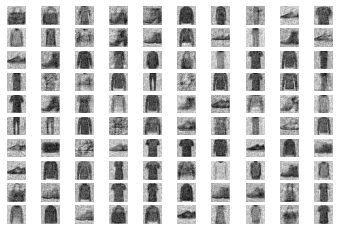

In [ ]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

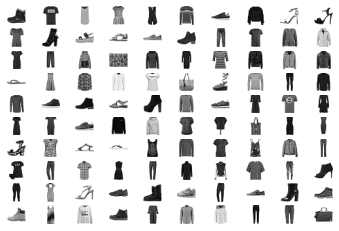

4/4 [==============================] - 0s 4ms/step


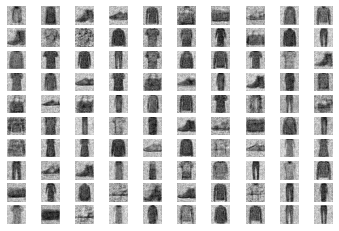

In [ ]:
latent_dim = 100
n_examples = 100
X = X_train
X = (X + 1) / 2.0
save_plot(X, n_examples)

model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

**GANs 2**

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [ ]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

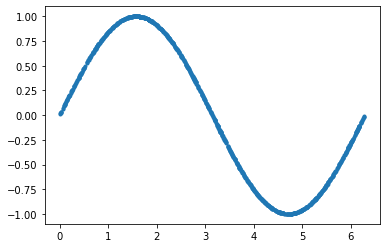

In [ ]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
generator = Generator()

In [ ]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [ ]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.2984756827354431
Epoch: 0 Loss G.: 2.6666221618652344
Epoch: 10 Loss D.: 0.6828275322914124
Epoch: 10 Loss G.: 1.271045207977295
Epoch: 20 Loss D.: 0.6088209748268127
Epoch: 20 Loss G.: 0.949321448802948
Epoch: 30 Loss D.: 0.6321682333946228
Epoch: 30 Loss G.: 0.8533194661140442
Epoch: 40 Loss D.: 0.6196314096450806
Epoch: 40 Loss G.: 0.9147428274154663
Epoch: 50 Loss D.: 0.7219336628913879
Epoch: 50 Loss G.: 1.0218039751052856
Epoch: 60 Loss D.: 0.6355721950531006
Epoch: 60 Loss G.: 0.8299963474273682
Epoch: 70 Loss D.: 0.6757482290267944
Epoch: 70 Loss G.: 0.7728537321090698
Epoch: 80 Loss D.: 0.6438236236572266
Epoch: 80 Loss G.: 0.8605951070785522
Epoch: 90 Loss D.: 0.7075463533401489
Epoch: 90 Loss G.: 0.7051045298576355
Epoch: 100 Loss D.: 0.6970354318618774
Epoch: 100 Loss G.: 0.6877041459083557
Epoch: 110 Loss D.: 0.6852482557296753
Epoch: 110 Loss G.: 0.7445094585418701
Epoch: 120 Loss D.: 0.6835842728614807
Epoch: 120 Loss G.: 0.658311128616333
Epoch: 130 

In [ ]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

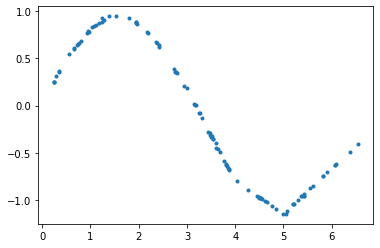

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")